# Developing an AI application

In this project, I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at.  We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories.


The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import json
from math import floor
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.patches as mpatches

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


import numpy as np

from collections import OrderedDict


from PIL import Image

import pandas as pd
#from torchsample.modules import ModuleTrainer

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMAGE = {'size': 256,
         'crop': (224, 224),
         'means': [0.485, 0.456, 0.406],
         'std': [0.229, 0.224, 0.225]}
BATCH_SIZES = (64, 64, 32)

## Load the data

Here i'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into three parts, training, validation, and testing. For the training, I'll apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. 
For all three sets I'll normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [14]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [15]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([          
    transforms.RandomResizedCrop(IMAGE['crop'][0]),
    transforms.ToTensor(),
    transforms.Normalize(IMAGE['means'], IMAGE['std']),
])

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE['size']),                                
    transforms.CenterCrop(IMAGE['crop'][0]),
    transforms.ToTensor(),
    transforms.Normalize(IMAGE['means'], IMAGE['std']),
])

# Load the datasets with ImageFolder
training_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_datasets = datasets.ImageFolder(valid_dir, transform=data_transforms)
testing_datasets = datasets.ImageFolder(test_dir, transform=data_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_datasets, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_datasets, batch_size=64, shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_datasets, batch_size=32)

I kept all transformations simple as tried out dozen of parameters and played with random ones but none of them gave that high result as straightforward resizing and center cropping. 

In [3]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
    
def get_info(directory, mapping):
    data = {}
    for root, d, f in os.walk(directory):
        if len(f)!=0:
            dir_num = root.split('/')[2]
            data[mapping.get(dir_num)] = len(f)
    return zip(*sorted(data.items(), key=itemgetter(1)))    


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101]),
 <a list of 102 Text xticklabel objects>)

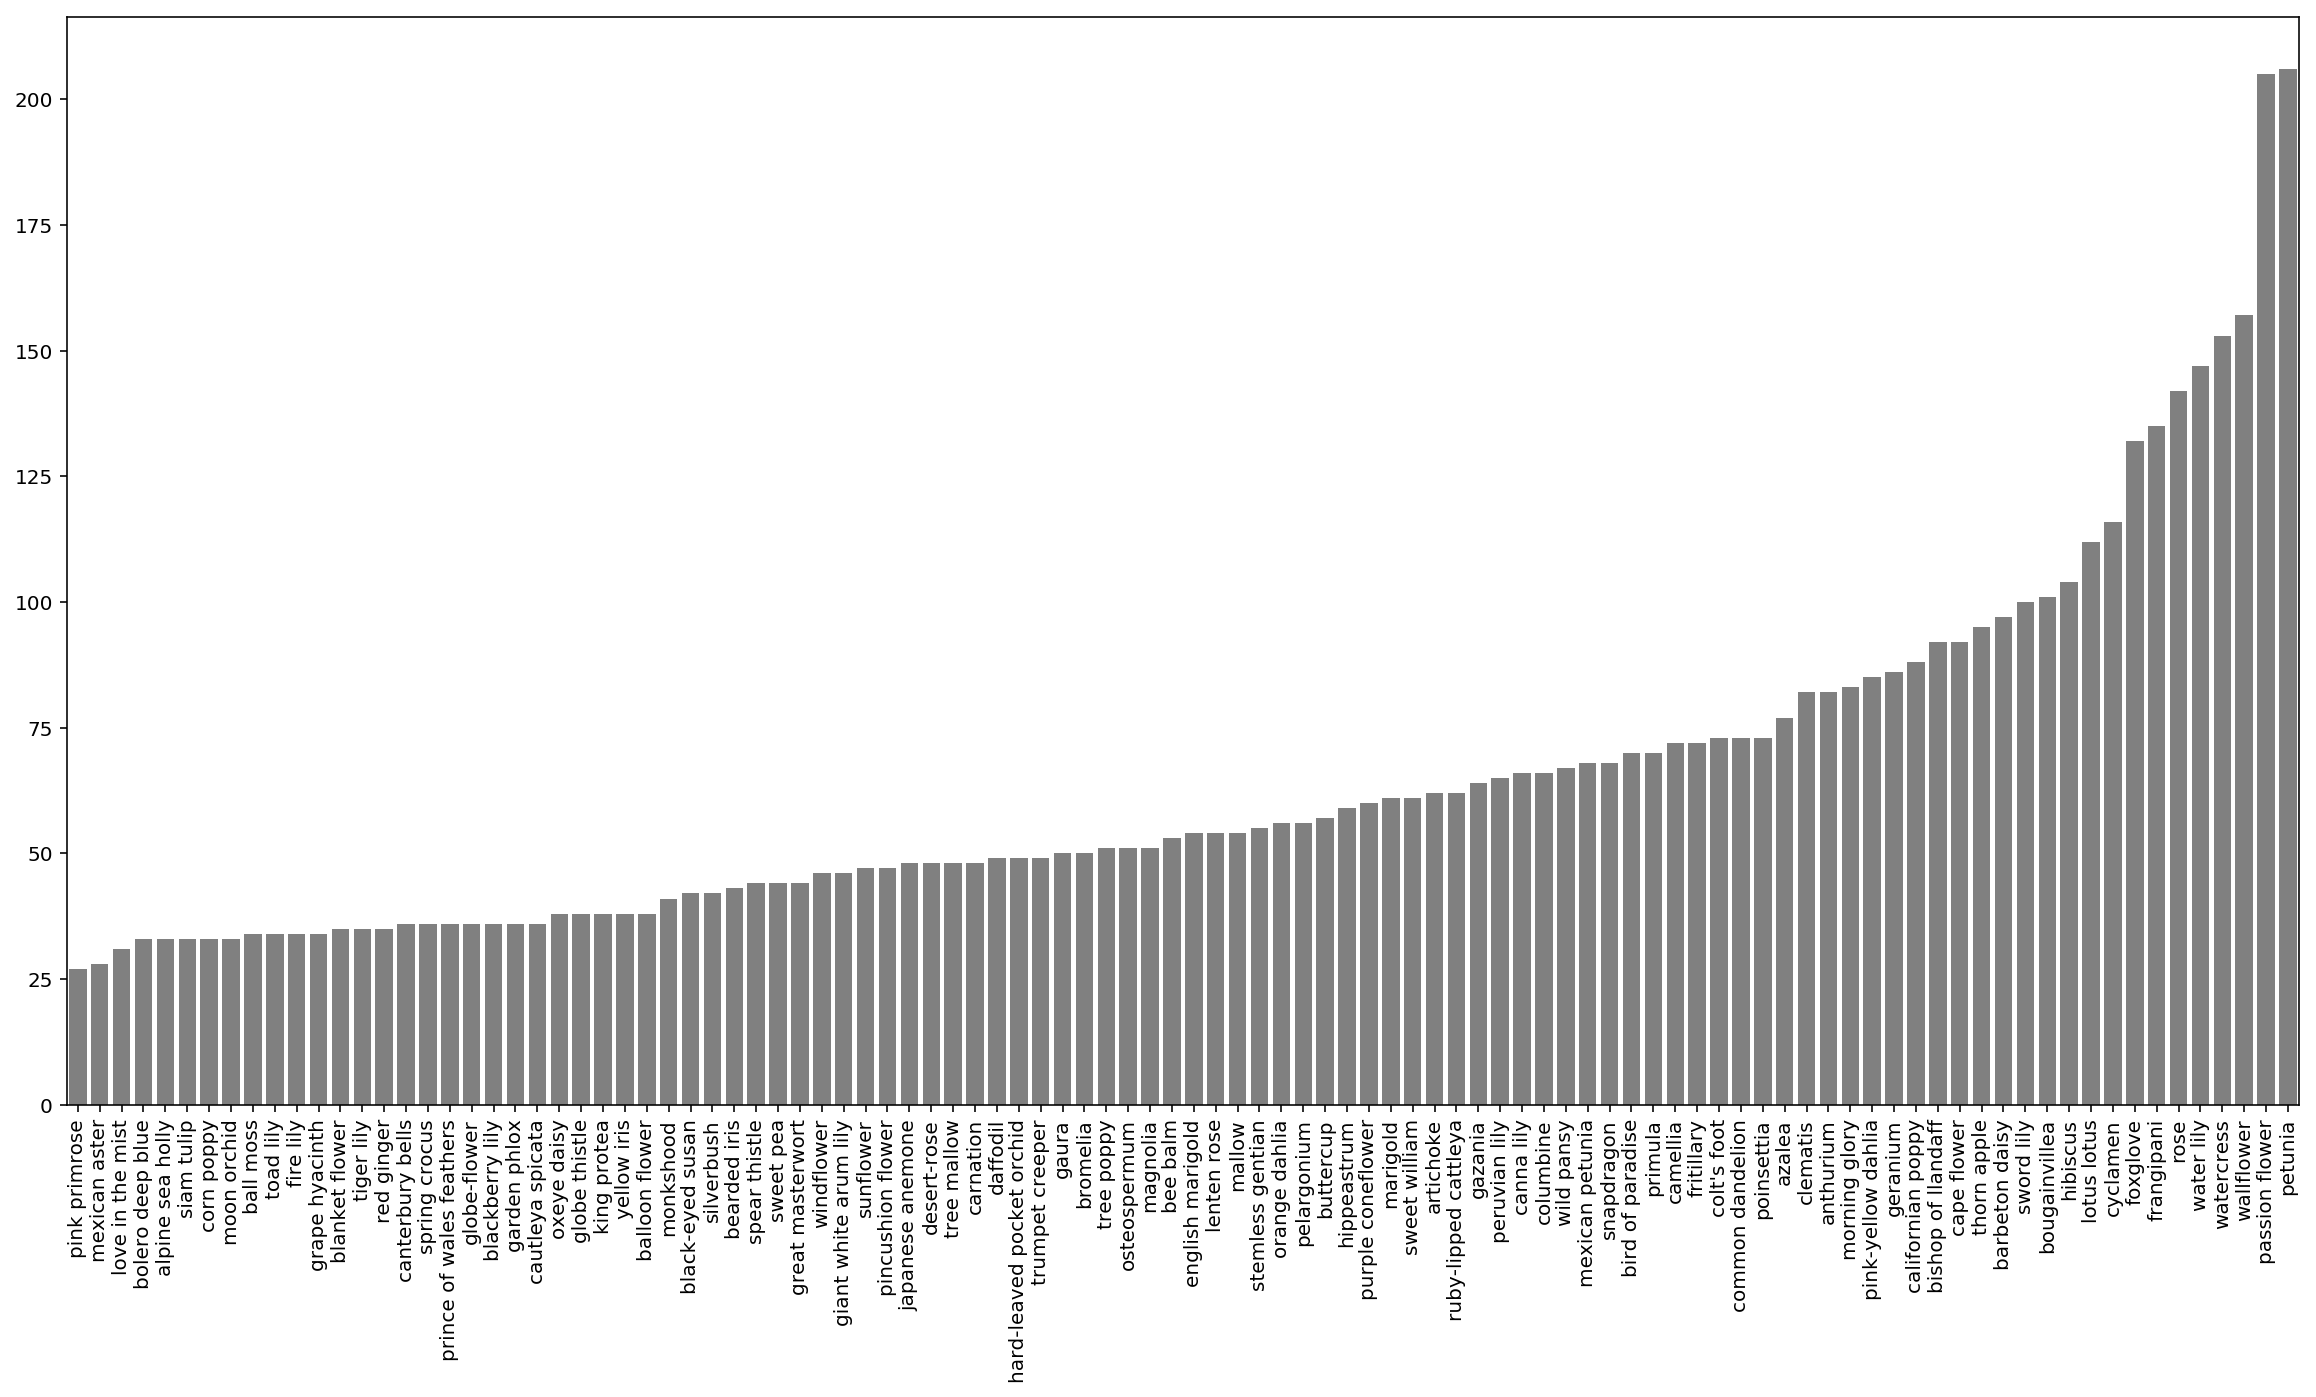

In [6]:
f = plt.figure(figsize=(20,10))
x,y = get_info(train_dir, cat_to_name)
sn.barplot(x = list(x), y = list(y), color='grey')
plt.xticks(rotation=90)

There was group of flowers ~10 that over-represented comparing to others. Likely those flowers would have identified the way better than others.

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101]),
 <a list of 102 Text xticklabel objects>)

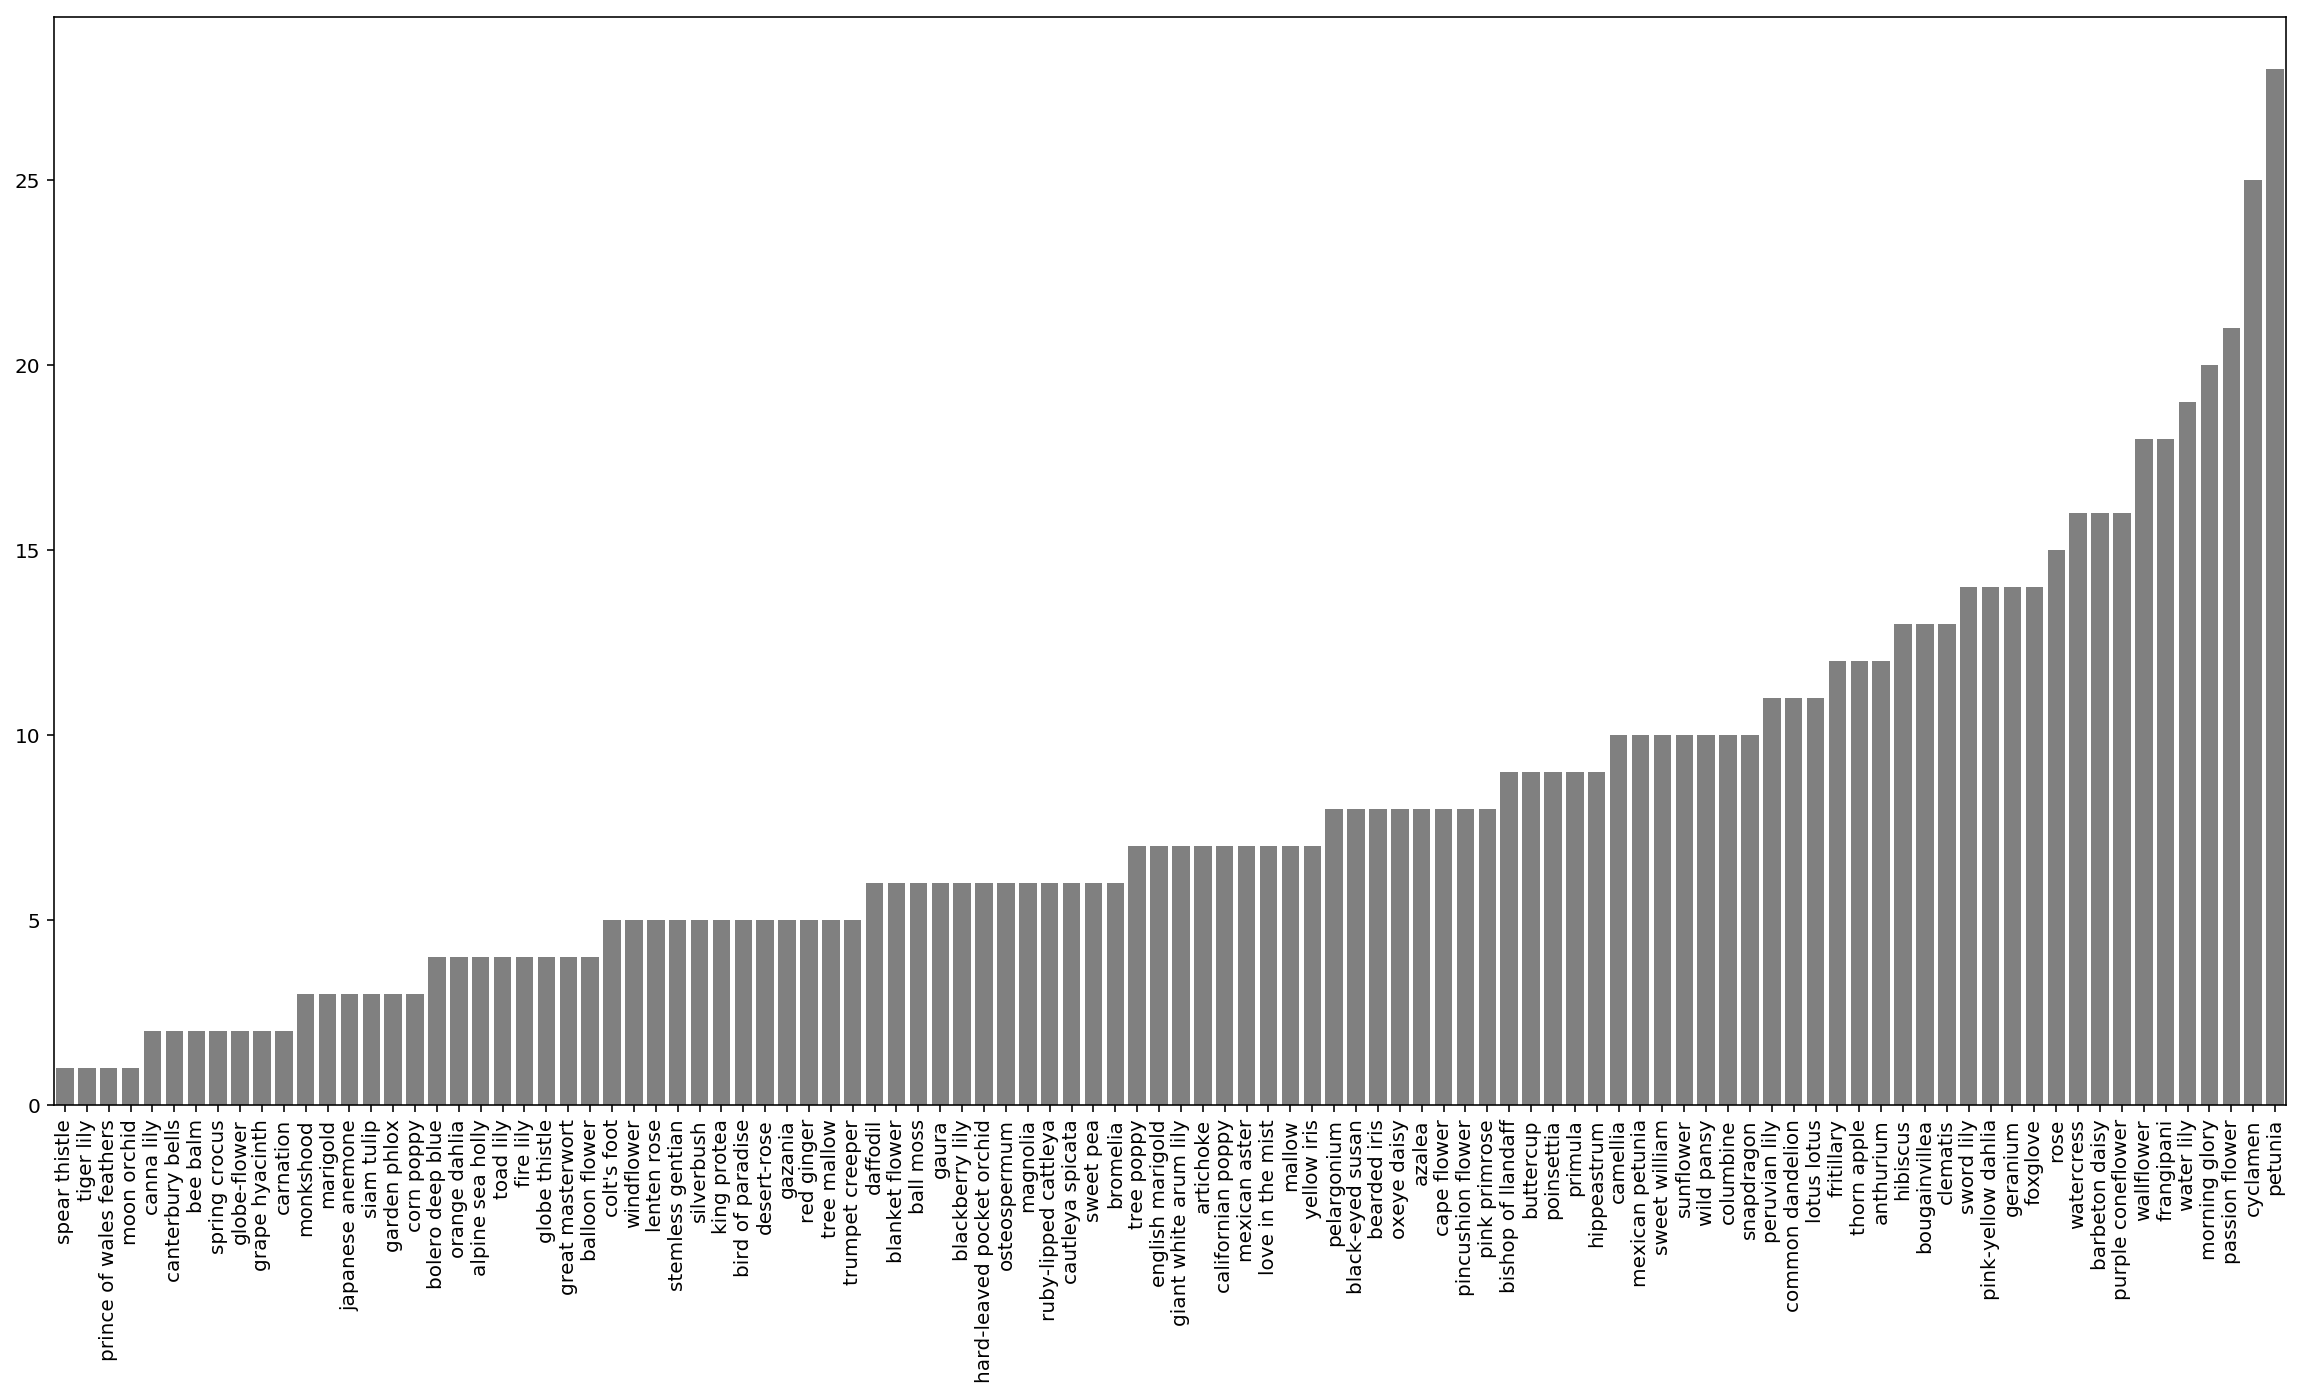

In [7]:
f = plt.figure(figsize=(20,10))
x,y = get_info(valid_dir, cat_to_name)
sn.barplot(x = list(x), y = list(y), color='grey')
plt.xticks(rotation=90)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101]),
 <a list of 102 Text xticklabel objects>)

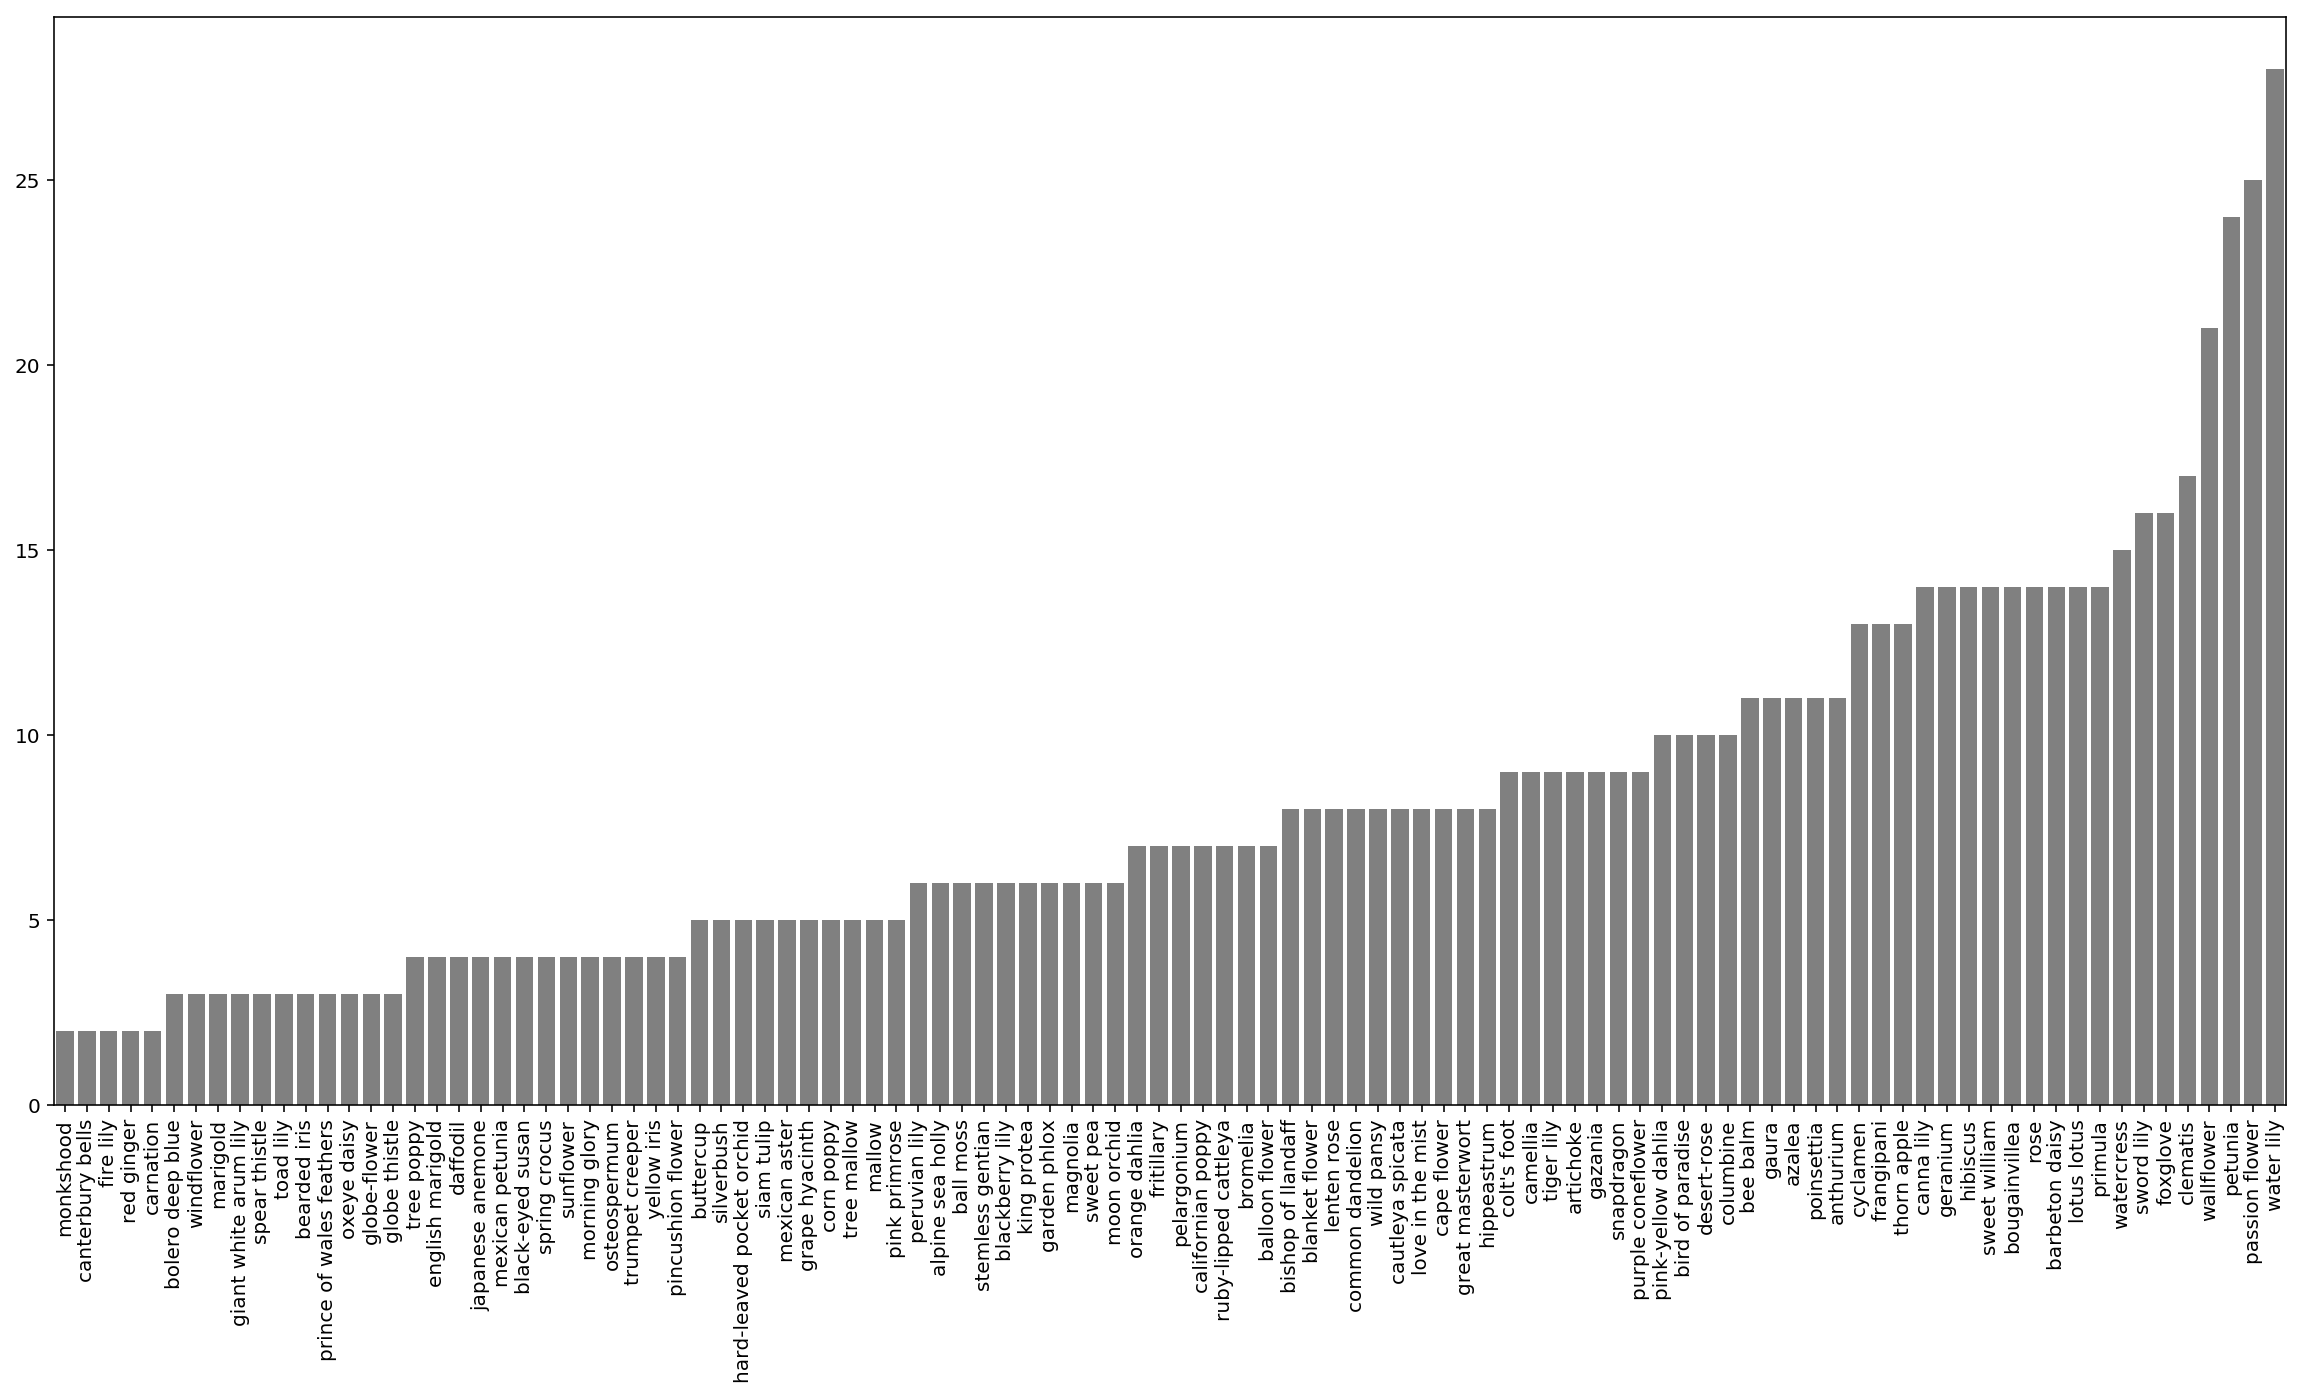

In [8]:
f = plt.figure(figsize=(20,10))
x,y = get_info(test_dir, cat_to_name)
sn.barplot(x = list(x), y = list(y), color='grey')
plt.xticks(rotation=90)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

I am going to use one of the available 'torchvision.models' which is VGG11. As a first step we need to make sure that we are updating only the weights of feed-forward network (classifier). Classifier itself we will provide later.

In [5]:
def get_pretrained_network(network, pre=True, device='cpu', no_grad=False, classifier=None):
    """
    Get pre-trained network and switch off gradient calculation. Swap classifier with provided and put Tensors to actual
    type of device (cuda or cpu).
    """
    model = network(pretrained=pre)
    for p in model.parameters():
        p.requires_grad = no_grad
    if classifier:
        model.classifier = classifier
    model.to(device)
    return model

Below I tried number of classifiers with different layers, learning rates and dropout probablities. It resulted in 3 tier architecture with 12800 in-features and 102 out. I tested out network with dropout option but it did not improve overall result at all. Have I done something wrong ? Between layers there are 2 RELU activation functions and log soft max as final node giving logits. Also I kept number of epochs at 5 as it would yied fastest acceptable rate over 85%.

To assess performance of our model we need to come up with validation function which will be using validation set that has not been used during training. Each k iteration of learning we will be calling this function to see intermidiate result of learning and assess how well model generialize types of flowers on unseen set.

In [10]:
def validate(model, test_loader, criterion):
    """
    Put model in evaluation state and alculate losses on validation set.
    Return: mean accuracy and mean validation loss.
    """
    test_loss = 0
    acc = 0
    total=0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            test_loss+=criterion(output, labels).item()
            _, pred = torch.max(output.data, 1)
            total+=labels.size(0)
            acc+=(pred == labels).sum().item()
    model.train()
    return (round(acc/total, 2), round(test_loss/len(test_loader), 4))

In [18]:
def train_model(n_epoch=5, steps_to_interm_res=40, criterion=None, optimizer=None):
    
    """
    Train feed forward network number of epochs and print result after steps_to_interm_res. Store result after each 
    epoch to dictionary.
    """
    steps = 0
    epoch_results = {}
    epoch_storage = []
    
    if criterion is None:
        criterion = nn.NLLLoss()
    
    for i in keep_awake(range(n_epoch)):
        r_loss = 0
        test_loss = 0
        acc = 0
        for ii, (inp, lbl) in enumerate(train_loader):
            steps+=1
            inp, lbl = inp.to(device), lbl.to(device)
            optimizer.zero_grad()
            output = model.forward(inp)
            loss = criterion(output, lbl)
            loss.backward()
            optimizer.step()
            r_loss+=loss.item()

            if steps % steps_to_interm_res == 0:
                acc, test_loss = validate(model, valid_loader, criterion)
                print("Epoch {} out of {}".format(i+1, n_epoch))
                print("Running training loss {:.4f}".format(r_loss/ ((i+1)*steps_to_interm_res)))
                print("Running validation loss {:.4f}".format(test_loss))
                print("Accuracy {}%".format(100*acc))
#                 r_loss=0

        
        epoch_results['training_loss'] = r_loss/len(train_loader)
        epoch_results['validation_loss'] = test_loss
        epoch_results['acc'] = acc
        print(epoch_results['training_loss'], epoch_results['validation_loss'],epoch_results['acc'])
        epoch_storage.append(epoch_results.copy())
    return epoch_storage

Lets define classifier. As I have gone through the number of test runs I am going to keep classifier very simple. 3 layers with 2 activation functions and soft max as output. Later we will need to convert result to probabilities.

In [19]:
def build_classifier(in_features, out_features, act , out):
    network = []
    c = list(zip(in_features, out_features))
    for j, i in enumerate(c):
        network.append(('L'+str(j), nn.Linear(*i)))
        if len(c)!= j+1:
            network.append(('A'+str(j), act()))
    network.append(('out', out(dim=1)))
    return nn.Sequential(OrderedDict(network))

In [20]:
clas = build_classifier([12800, 2500, 250], 
                        [2500, 250, 102], 
                        nn.ReLU, 
                        nn.LogSoftmax)

model = get_pretrained_network(network=network, 
                               device=device, 
                               no_grad=False, 
                               classifier=clas)

epoch_storage = train_model(n_epoch=25, 
                            criterion = nn.NLLLoss(), 
                            optimizer= optim.Adam(model.classifier.parameters(), lr=0.0005))

Epoch 1 out of 25
Running training loss 3.5596
Running validation loss 2.0085
Accuracy 51.0%
Epoch 1 out of 25
Running training loss 5.5722
Running validation loss 1.1082
Accuracy 71.0%
2.523221522858999 1.1082 0.71
Epoch 2 out of 25
Running training loss 0.2705
Running validation loss 0.7286
Accuracy 79.0%
Epoch 2 out of 25
Running training loss 0.8640
Running validation loss 0.7296
Accuracy 81.0%
Epoch 2 out of 25
Running training loss 1.4088
Running validation loss 0.6137
Accuracy 84.0%
1.1537244939109654 0.6137 0.84
Epoch 3 out of 25
Running training loss 0.2600
Running validation loss 0.5222
Accuracy 86.0%
Epoch 3 out of 25
Running training loss 0.5477
Running validation loss 0.5154
Accuracy 87.0%
0.8895585045073796 0.5154 0.87
Epoch 4 out of 25
Running training loss 0.0545
Running validation loss 0.4846
Accuracy 86.0%
Epoch 4 out of 25
Running training loss 0.2537
Running validation loss 0.4197
Accuracy 88.0%
Epoch 4 out of 25
Running training loss 0.4437
Running validation loss 

Best result I have gotten so far - 92% on validation set, 20 epochs, alpha=0.0005.
It seems that we could have terminated earlier saying beetwen 16 and 17 epoch.. or even the way earlier at 7 or 8. I am not going to use this last model but will load my previous checkpoint to proceed.
Update: Tested out all models with number of epochs ~20 and all of them seem weak. as were not able to pass sanity check due to generalization I guess. So I will stick to my old model that had been trained over 5 epochs.

[Text(0,0.5,'Accuracy'), Text(0.5,0,'Epoch')]

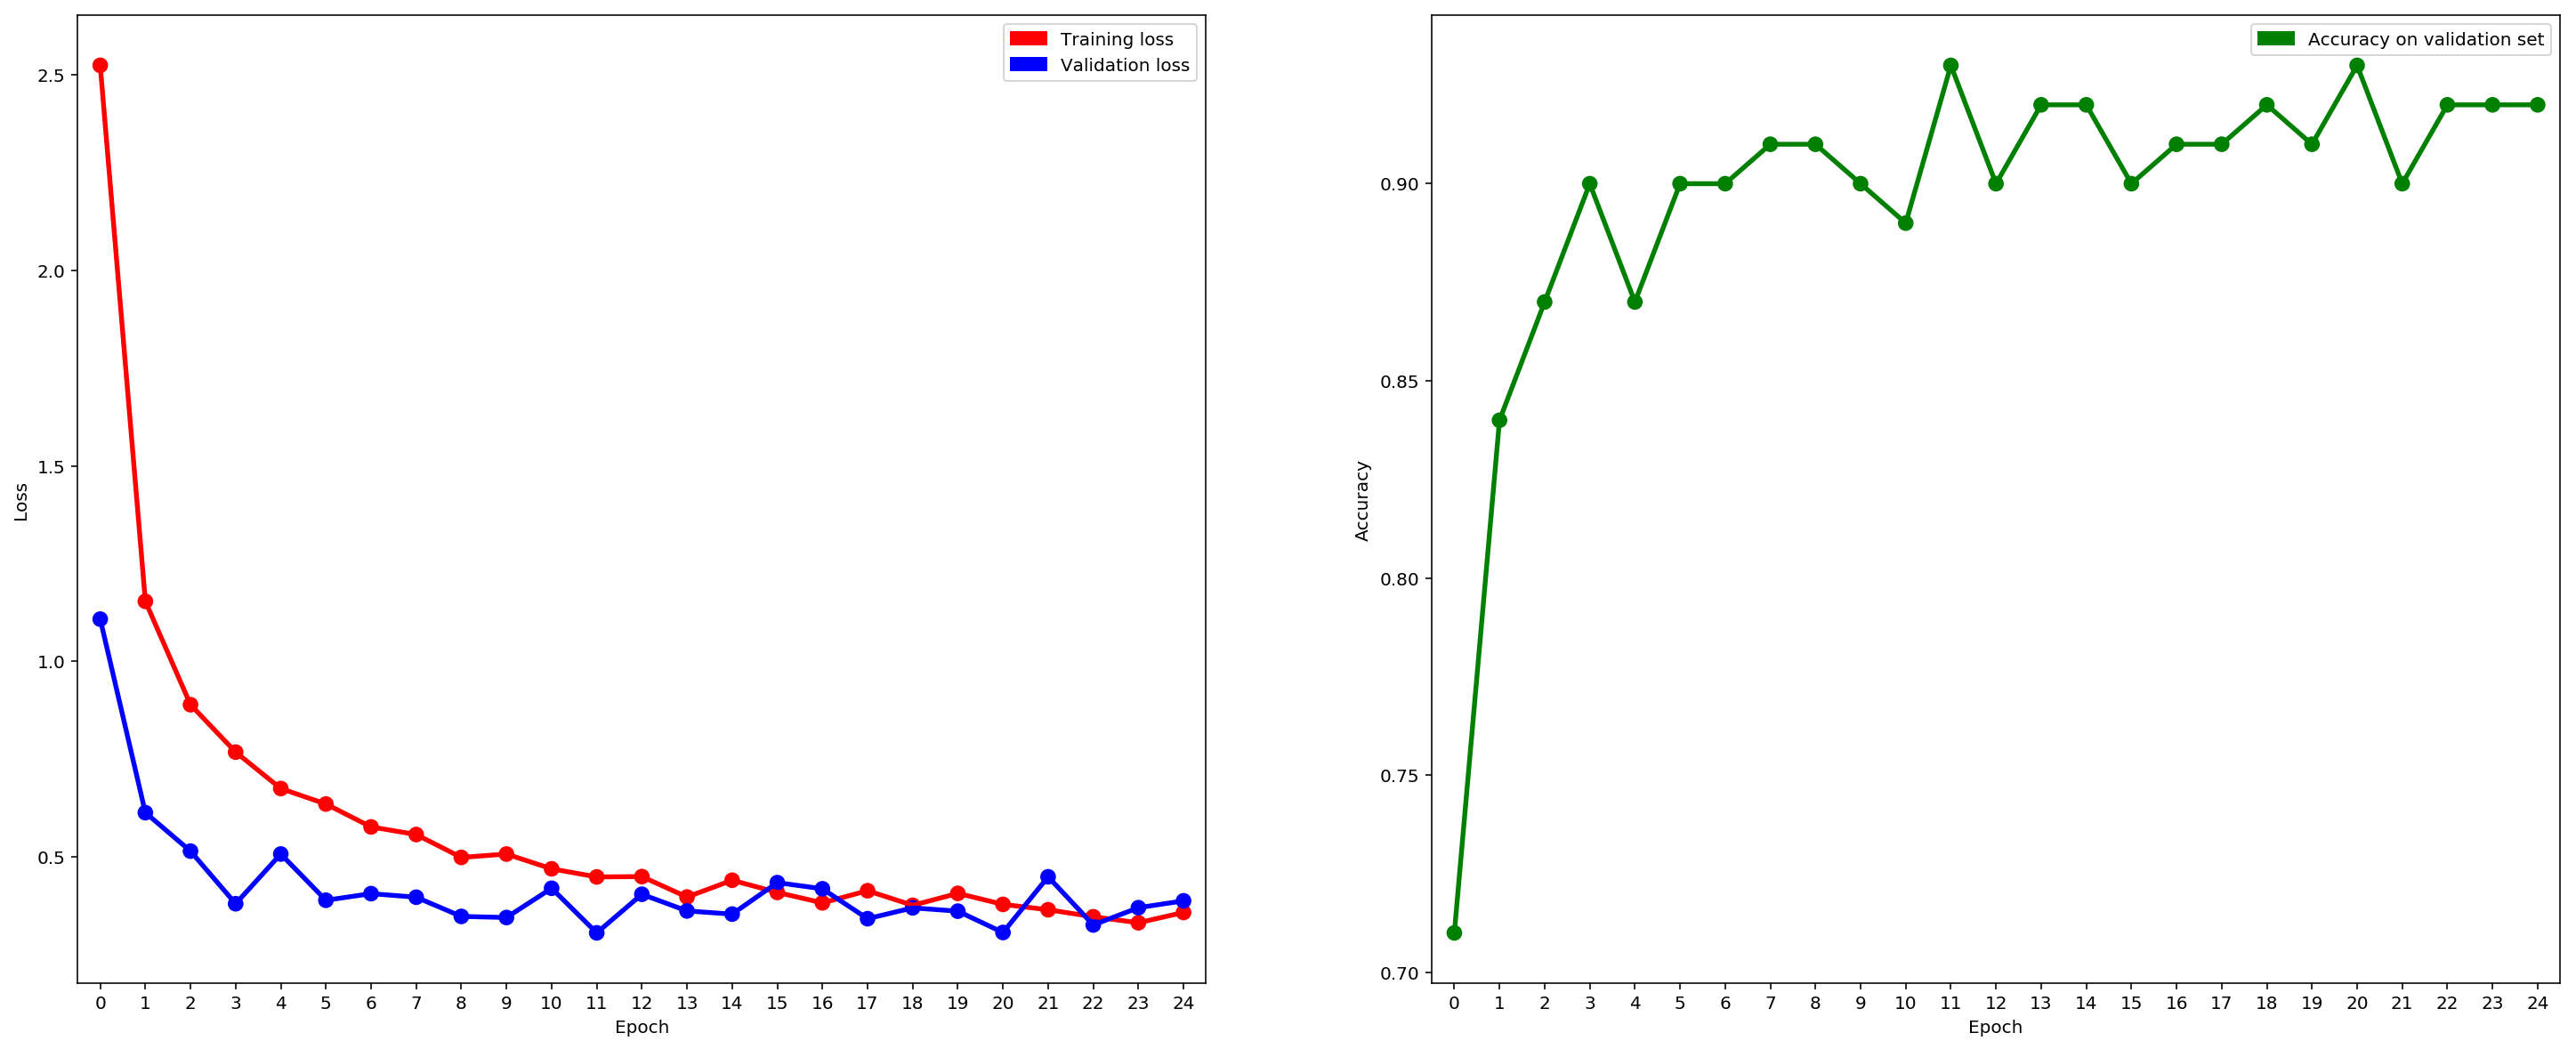

In [115]:

f, ax = plt.subplots(1,2, figsize=(25,10))
l1 = sn.pointplot(data=df_model_performance, x=df_model_performance.index, y='training_loss', color='red', ax=ax[0])
sn.pointplot(data=df_model_performance, x=df_model_performance.index, y='validation_loss', color='blue', ax = ax[0])
l2 = sn.pointplot(data=df_model_performance, x=df_model_performance.index, y='acc', ax=ax[1], color='green')

red_patch = mpatches.Patch(color='red', label='Training loss')
blue_patch = mpatches.Patch(color='blue', label='Validation loss')
green_patch = mpatches.Patch(color='green', label='Accuracy on validation set')
l1.legend(handles=[red_patch, blue_patch])
l2.legend(handles=[green_patch])

l1.set(xlabel='Epoch', ylabel='Loss')
l2.set(xlabel='Epoch', ylabel='Accuracy')

## Testing your network

Lets test network out on testing set of flowers. 

In [38]:
model = model.float()
acc, _ = validate(model, testing_loader, nn.NLLLoss())
print("Accuracy on testing set is {} %".format(100*acc))
print("Loss on testing set is {} ".format(_))

Accuracy on testing set is 84.0 %
Loss on testing set is 0.6083 


## Save the checkpoint

Now that my network is trained, I will save the model so I can load it later for making predictions. Later I am going to use this for inference. I also included all the related information as number of epochs, classifier, layers, each epoch learning results on training and testing sets.

In [7]:
def save_model(check, filename):
    torch.save(check, filename)
    
def load_model(arch='vgg11', filename='checkpoint_new.pth', device='cpu'):
    model_file = torch.load(filename, map_location=lambda storage, loc: storage)
    n = Network(arch=model_file['network'], device=device)
    n.classifier = model_file['classifier']
    n.idx = model_file['classes']
    n.epoch_storage = model_file['epoch_res']
    n.model.load_state_dict(model_file['state_dict'])
    n.model.to(device)
    return n

In [35]:
checkpoint = {
              'classifier': model.classifier,
              'state_dict': model.state_dict(),
              'epoch_res' : epoch_storage,
              'classes': training_datasets.class_to_idx,
              'network': 'vgg11'
              }
save_model(checkpoint, 'checkpoint_new_epoch25_91_t.pth')

## Loading the checkpoint

Lest create a function to load up stored check point so we can get to any model we have trained earlier.

In [32]:
#model = get_pretrained_network(models.vgg11, device=device)
model = load_model('checkpoint_new_epoch4_88.pth')
model.classifier

Sequential(
  (l1): Linear(in_features=12800, out_features=2500, bias=True)
  (act1): ReLU()
  (l2): Linear(in_features=2500, out_features=250, bias=True)
  (l3): Linear(in_features=250, out_features=102, bias=True)
  (output): LogSoftmax()
)

# Inference for classification

To use our network on single sample we need to make some preparations. First we need to process our image : load, resize, apply transformations to comply with network and crop from center probably. 

## Image Preprocessing

Lets use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

- First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio.
- Then you'll need to crop out the center 224x224 portion of the image.
- Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. 
- Normalize.
- Transpose dimensions: PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. 

In [16]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = Image.open(image)
    width, height = im.size
    if width == height:
        im.thumbnail((IMAGE['size'], IMAGE['size']), Image.ANTIALIAS)
    if width > 256 or height > 256:
        if width > height:
            ratio = 256 / width
        else:
            ratio = 256 / height
    r_image= im.resize((floor(ratio * height), floor(ratio * width)))
    w, h = r_image.size
    l, t = ((w - IMAGE['crop'][0]) / 2, (h - IMAGE['crop'][1]) / 2)
    r, b = ((w + IMAGE['crop'][0]) / 2, (h + IMAGE['crop'][1]) / 2)
    r_image = r_image.crop((l, t, r, b))
    np_image = np.array(r_image)
    np_image = np_image / 255
    for i, value in enumerate(np_image, 0):
        for j, value2 in enumerate(np_image[i], 0):
            np_image[i, j] = (np_image[i][j] - np.array(IMAGE['means'])) / np.array(IMAGE['std'])
    return np_image.transpose((2, 1, 0))

To check work, the function below converts a PyTorch tensor and displays it in the notebook.

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

I downloaded random image from the internet that was "gazania".

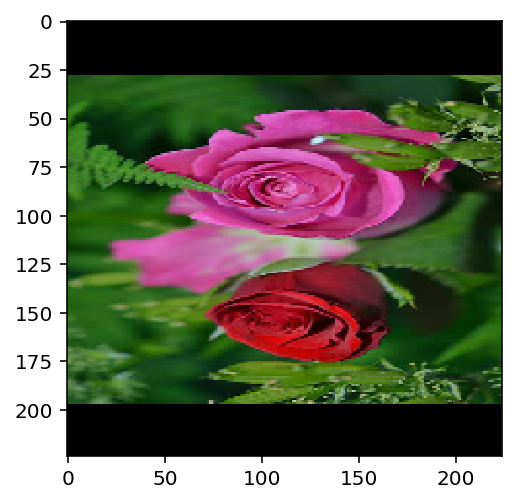

In [20]:
img = process_image(data_dir+'/rose.jpeg')
imshow(img)

## Class Prediction

Now we have function to transform image created it is time to make a prediction. Lets create function to predict top k largest values. To do that we need to put our model into evaluation mode and pass our transformed image. Once that is done we conver logits to probabilities and filtering out everything but top 5.

In [34]:
def index_prob(path, probs, labels, k=5):
    """
    Get top k probabilities and return real names of idx classes.
    """
    pid = torch.topk(probs, k)[1][0].cpu().numpy()
    ps = torch.topk(probs, k)[0][0].cpu().numpy()
    ids = [load_mapping(path).get(reverse_idx(labels, x)) for x in pid]
    return ps, ids

def reverse_idx(labels ,idx):
    """
    Match labels by idx class
    """
    for k,v in labels.items():
        if v == int(idx):
            return k
        
def predict(self, image_path, mapping_path, topk=3):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    :param image_path: path to image
    :mapping_path: path mapping json file
    :return: probabilities
    """
    img = process_image(image_path)
    self.model.eval()
    img = torch.from_numpy(img).to(self.device)
    img.unsqueeze_(0)
    model = self.model.double()
    with torch.no_grad():
        o = model.forward(img)
        ps = torch.exp(o)
        data = index_prob(mapping_path, ps, self.idx, k=topk)
        res = list(zip(data[0], data[1]))
        for i in res:
            print("Probability:{}%".format(round(i[0] * 100, 3)), "Flower:{}".format(i[1]) + "\n")

In [24]:
def output_result(model, image, topk):
    """
    Output sample + top k predictions.
    """
    for i in image:
        im = Image.open(i, 'r')
        ps = predict(i, model, topk=topk)
        data = index_prob(ps, topk)
        f,ax = plt.subplots(1,2, figsize=(20, 5))
        ax[0].imshow(np.asarray(im))
        ax[1] = sn.barplot(x=data[0], y=data[1])

## Sanity Checking

I will take 4 random pictures from the internet of 4 groups representative which have few, medium, fair, high number of samples in our training set. Monkshood(~30 samples) - Stemless Giant(~50) - Gazania(~70), Rose (~125).

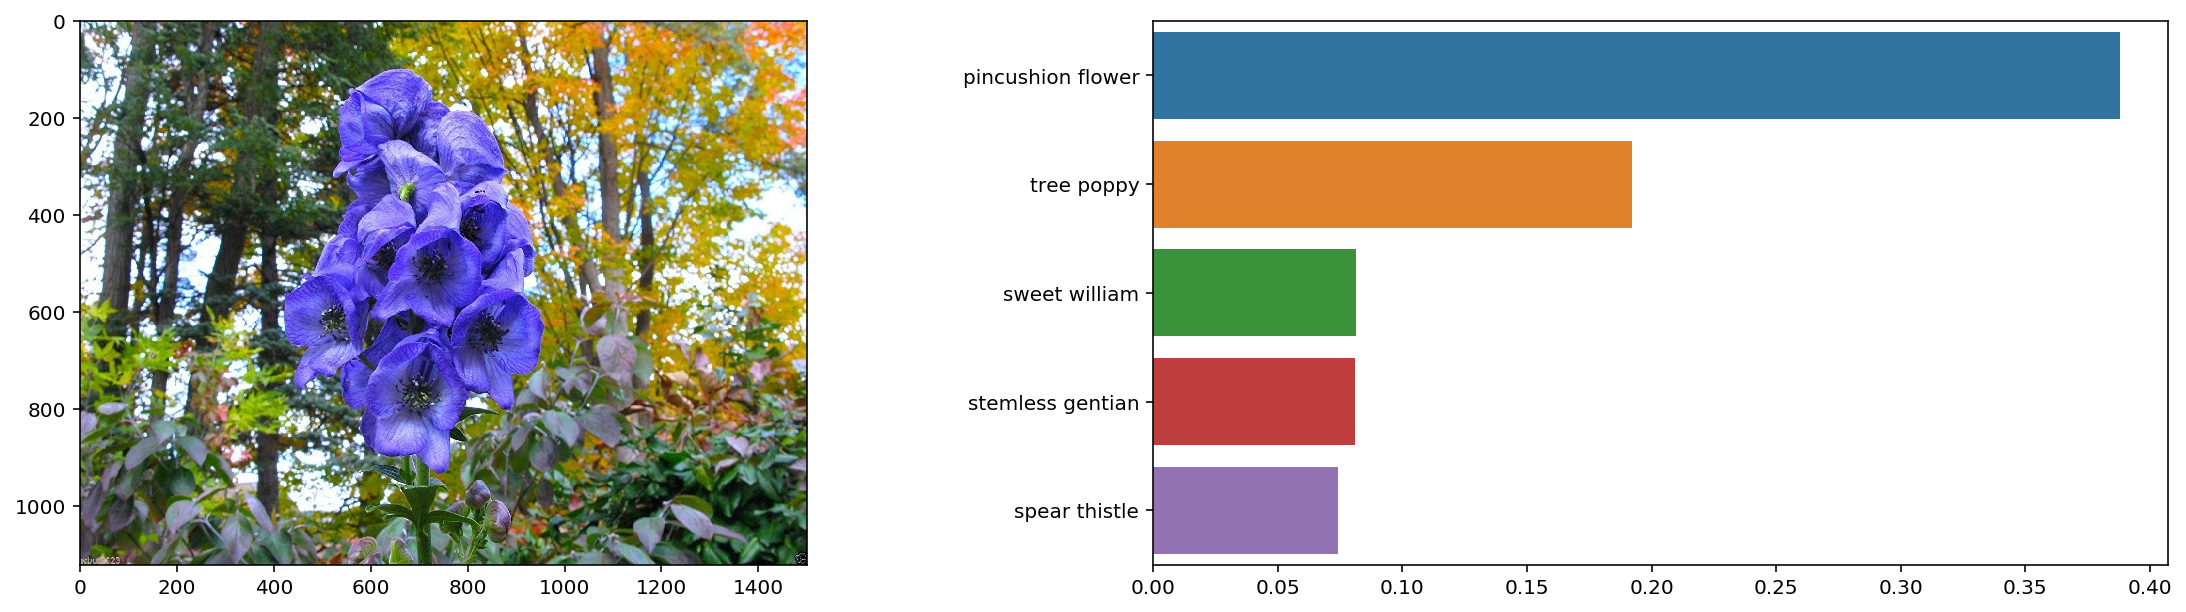

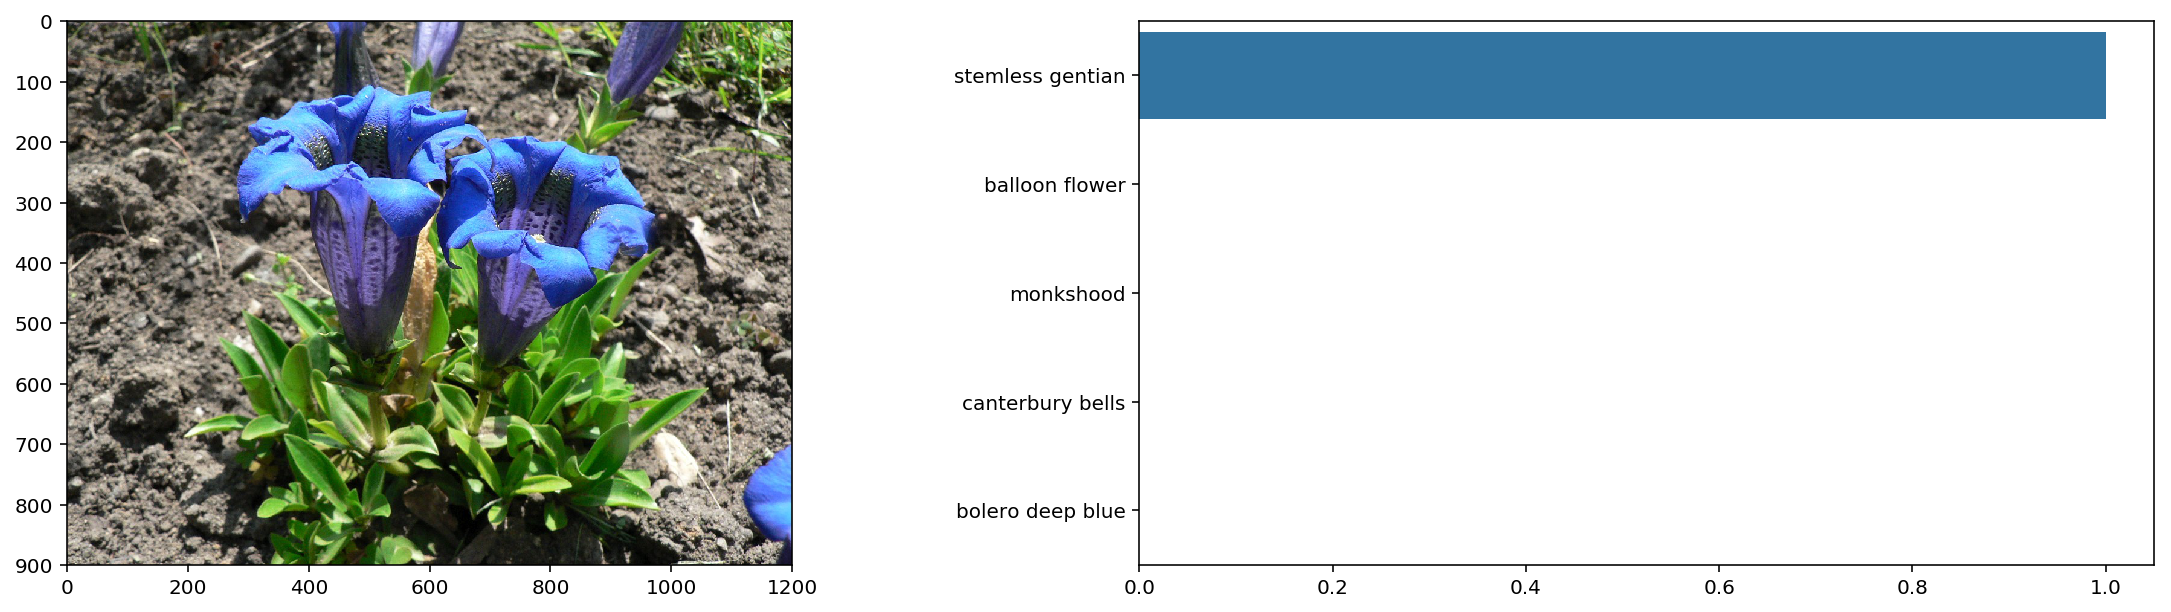

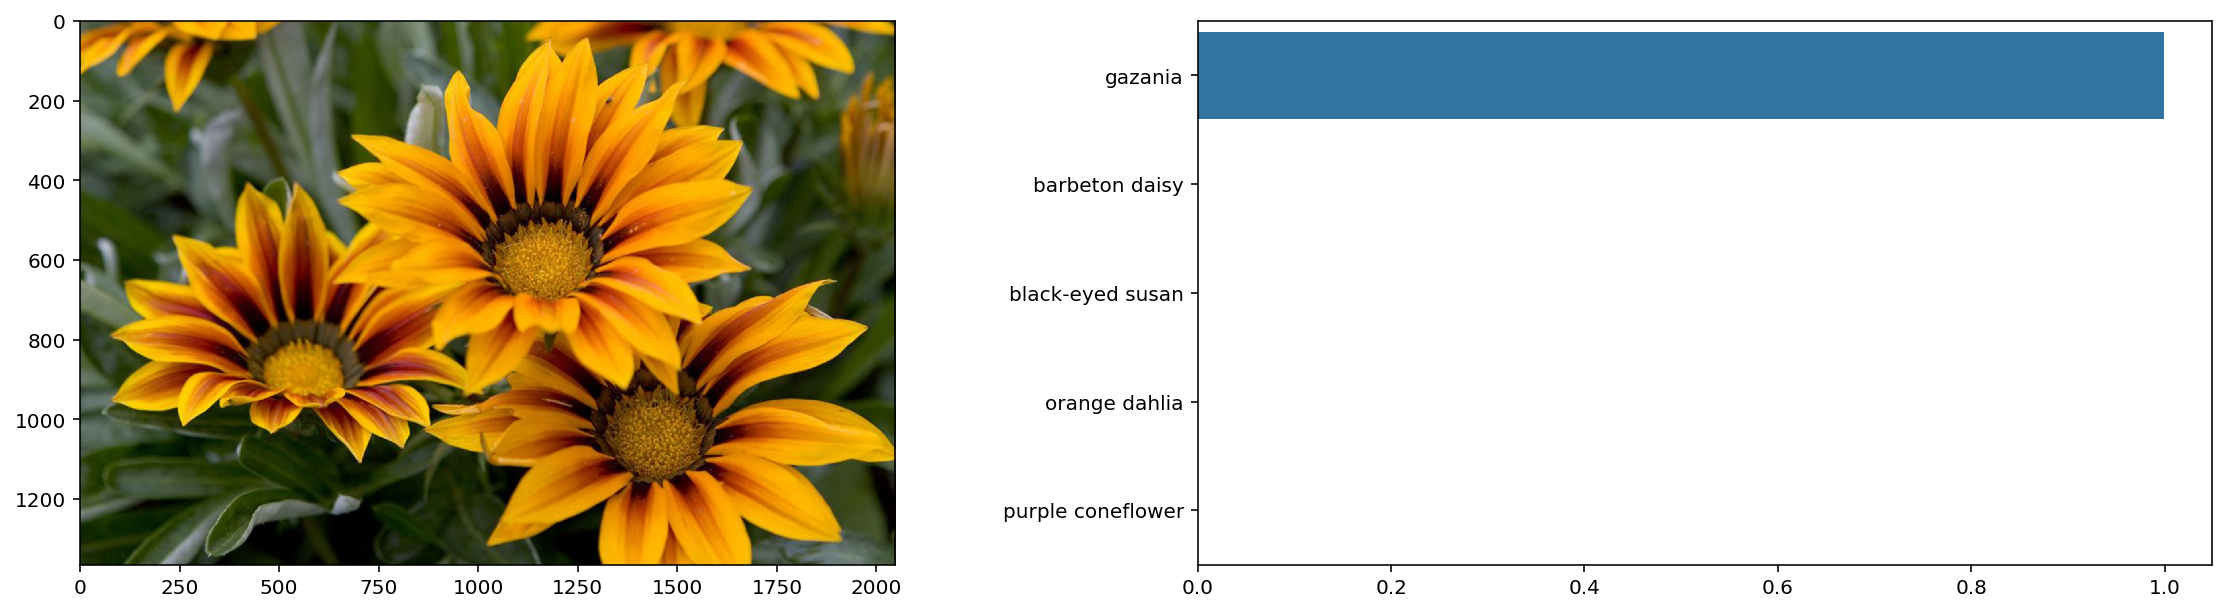

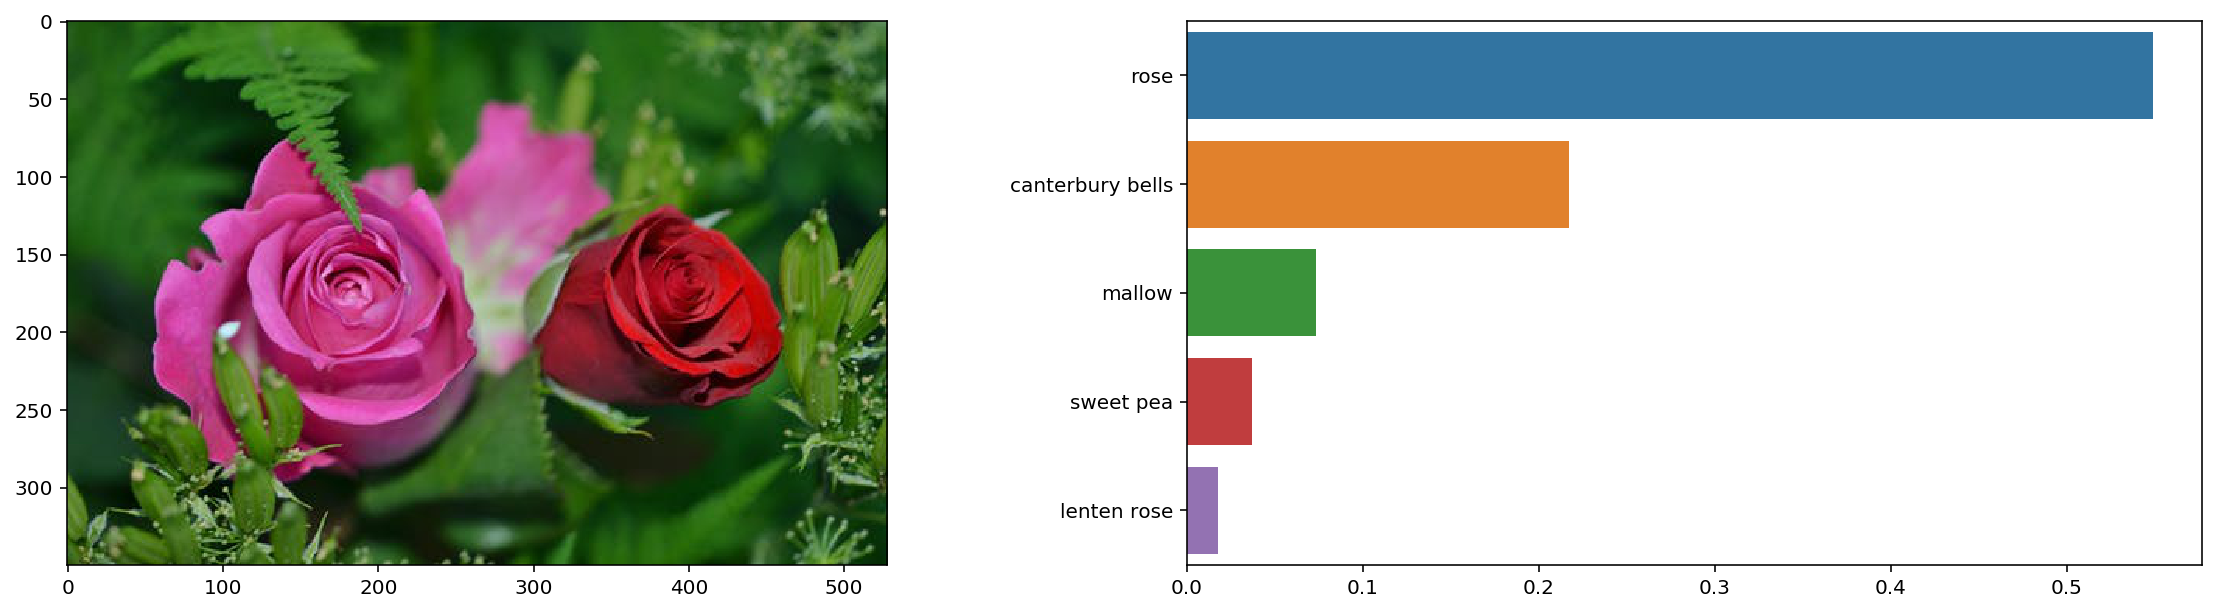

In [40]:
output_result(model, [data_dir+'/monkshood.jpg',
                      data_dir+'/stemless_g.jpg', 
                      data_dir+'/gazania_test.jpg', 
                      data_dir+'/rose.jpeg'], 
              5)

3 out of 4 were correctly identified. It worth adding more samples in order to increase chances of monkhood to be recognized. Lets try another one from those with low sample size in training set.

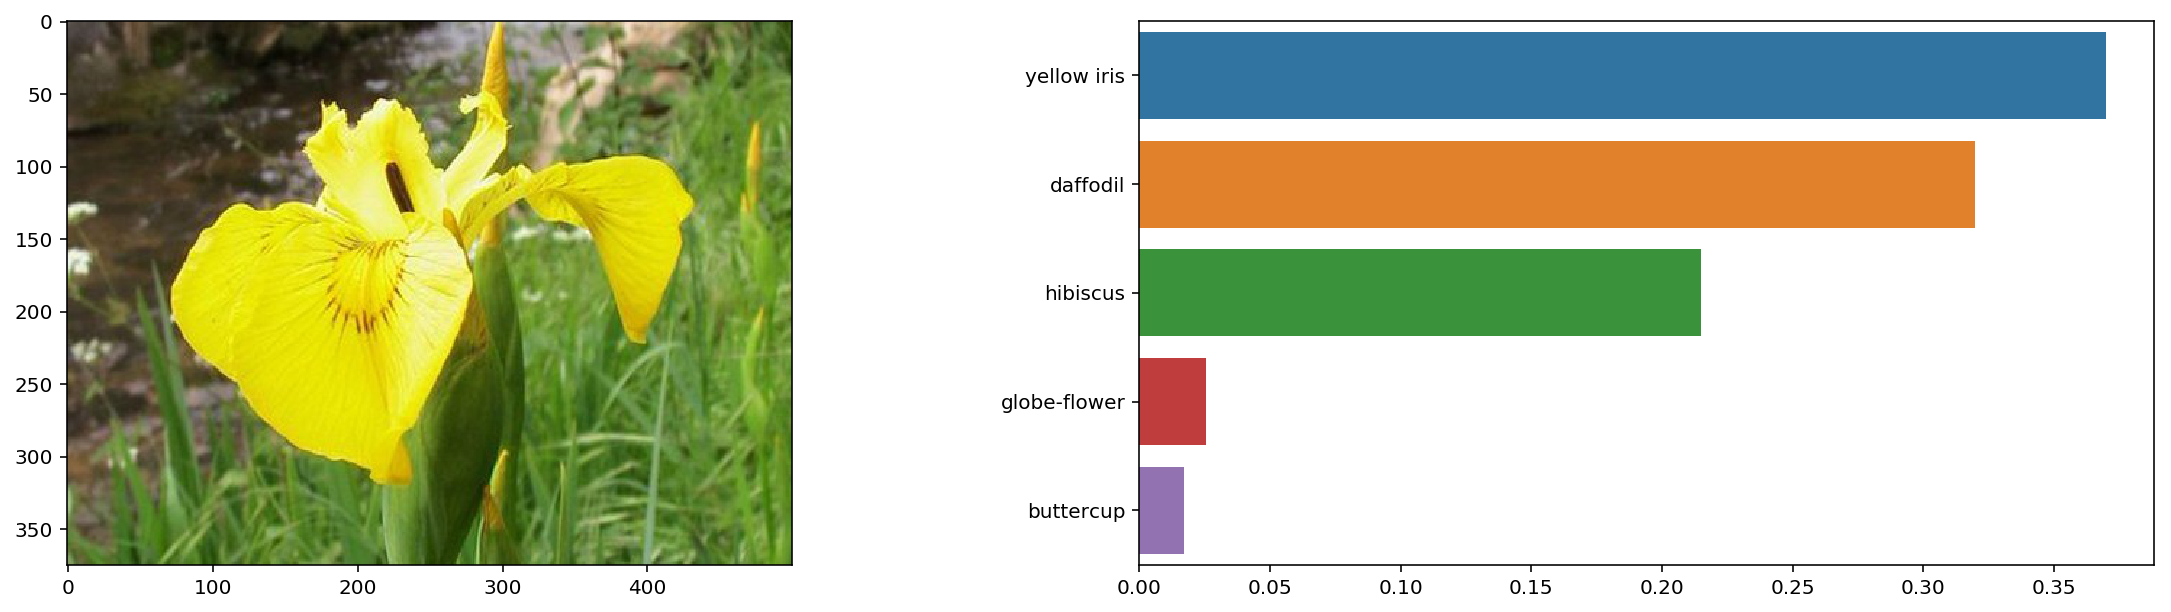

In [36]:
output_result(model, [data_dir + '/iris.jpg'], 5)

So it seems working in this case "yellow iris" correctly recognized. We can consider sanity check passed.